In [4]:
import torch
import random
import matplotlib.pyplot as plt
from torch_geometric.utils import negative_sampling

In [5]:
# Load the graphs
train_data = torch.load('data/undirected_train_graph.pt')
val_data   = torch.load('data/undirected_val_graph.pt')
test_data  = torch.load('data/undirected_test_graph.pt')


In [6]:
print('Undirected Training Data')
print('----------------------')
print(train_data)

print('Undirected Validation Data')
print('------------------------')
print(val_data)

print('Undirected Test Data')
print('------------------')
print(test_data)


Undirected Training Data
----------------------
HeteroData(
  lncRNA={ x=[1269, 2] },
  protein={ x=[11585, 2] },
  (lncRNA, interacts, protein)={
    edge_index=[2, 5119],
    edge_attr=[5119, 4],
  },
  (protein, interacts_rev, lncRNA)={
    edge_index=[2, 5119],
    edge_attr=[5119, 4],
  },
  (protein, interacts, protein)={
    edge_index=[2, 59544],
    edge_attr=[59544, 1],
  },
  (protein, interacts_rev, protein)={
    edge_index=[2, 59544],
    edge_attr=[59544, 1],
  }
)
Undirected Validation Data
------------------------
HeteroData(
  lncRNA={ x=[1269, 2] },
  protein={ x=[11585, 2] },
  (lncRNA, interacts, protein)={
    edge_index=[2, 640],
    edge_attr=[640, 4],
  },
  (protein, interacts_rev, lncRNA)={
    edge_index=[2, 640],
    edge_attr=[640, 4],
  },
  (protein, interacts, protein)={
    edge_index=[2, 7443],
    edge_attr=[7443, 1],
  },
  (protein, interacts_rev, protein)={
    edge_index=[2, 7443],
    edge_attr=[7443, 1],
  }
)
Undirected Test Data
-------------

In [7]:
from torch_geometric.utils import negative_sampling
import random

def smart_negative_edges_lncRNA_protein(data, edge_type, num_samples_per_lnc=5, seed=42):
    random.seed(seed)
    src_type, _, dst_type = edge_type
    num_lnc = data[src_type].x.size(0)
    num_prot = data[dst_type].x.size(0)

    pos_edge_index = data[edge_type].edge_index
    pos_set = set(map(tuple, pos_edge_index.t().tolist()))

    neg_edges = []

    for src in range(num_lnc):
        sampled = set()
        attempts = 0
        while len(sampled) < num_samples_per_lnc and attempts < 20 * num_samples_per_lnc:
            dst = random.randint(0, num_prot - 1)
            if (src, dst) not in pos_set and dst not in sampled:
                sampled.add(dst)
            attempts += 1

        for dst in sampled:
            neg_edges.append((src, dst))

    neg_edge_index = torch.tensor(neg_edges, dtype=torch.long).t().contiguous()
    return neg_edge_index

def generate_all_negatives(data, edge_types, split_name='train', ratio=1.0, num_samples_per_lnc_dict=None):
    """
    Generate negative samples for all edge types.
    Uses smart sampling for lncRNA → protein, and random for others.
    `split_name` helps select the appropriate sampling config.
    """
    results = {}

    if num_samples_per_lnc_dict is None:
        num_samples_per_lnc_dict = {'train': 5, 'val': 1, 'test': 1}

    for edge_type in edge_types:
        src_type, _, dst_type = edge_type
        pos_edge_index = data[edge_type].edge_index
        num_pos = pos_edge_index.size(1)
        num_nodes_src = data[src_type].x.size(0)
        num_nodes_dst = data[dst_type].x.size(0)

        if edge_type == ('lncRNA', 'interacts', 'protein'):
            # Use smarter sampling based on current split
            n_neg = num_samples_per_lnc_dict.get(split_name, 5)
            neg_edge_index = smart_negative_edges_lncRNA_protein(
                data, edge_type, num_samples_per_lnc=n_neg
            )
        else:
            # Use PyG negative sampling
            num_neg = int(num_pos * ratio)
            neg_edge_index = negative_sampling(
                edge_index=pos_edge_index,
                num_nodes=(num_nodes_src, num_nodes_dst),
                num_neg_samples=num_neg,
                method='sparse'
            )

        # Labels
        pos_labels = torch.ones(pos_edge_index.size(1), dtype=torch.float)
        neg_labels = torch.zeros(neg_edge_index.size(1), dtype=torch.float)
        edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=1)
        edge_label = torch.cat([pos_labels, neg_labels], dim=0)

        results[edge_type] = {
            'pos_edge_index': pos_edge_index,
            'neg_edge_index': neg_edge_index,
            'edge_index': edge_index,
            'edge_label': edge_label
        }

    return results


In [9]:
## add negative samples for just directed edges not reverses.
edge_types = [
    ('lncRNA', 'interacts', 'protein'),
    ('protein', 'interacts', 'protein'),
]


train_neg_samples = generate_all_negatives(
    train_data, edge_types, split_name='train',
    num_samples_per_lnc_dict={'train': 5, 'val': 1}
    )


In [11]:
for etype in edge_types:
    res = train_neg_samples[etype]
    print(f"\nEdge type: {etype}")
    print("  pos edges:", res['pos_edge_index'].shape[1])
    print("  neg edges:", res['neg_edge_index'].shape[1])
    print("  total:", res['edge_index'].shape[1])



Edge type: ('lncRNA', 'interacts', 'protein')
  pos edges: 5119
  neg edges: 6345
  total: 11464

Edge type: ('protein', 'interacts', 'protein')
  pos edges: 59544
  neg edges: 59544
  total: 119088


In [12]:
## invesigate more about out negative samples

def inspect_negative_samples_quality(data, neg_samples_dict):
    """
    Inspect the quality of negative samples per edge type.
    """
    for edge_type, sample in neg_samples_dict.items():
        print(f"\n=== Inspecting edge type: {edge_type} ===")

        pos_edge_index = sample['pos_edge_index']
        neg_edge_index = sample['neg_edge_index']

        # Check overlap
        pos_set = set(map(tuple, pos_edge_index.t().tolist()))
        neg_set = set(map(tuple, neg_edge_index.t().tolist()))
        overlap = pos_set.intersection(neg_set)
        print(f"False negatives (negatives found in positives): {len(overlap)}")

        # Unique nodes
        src_neg, dst_neg = neg_edge_index
        num_src = data[edge_type[0]].x.size(0)
        num_dst = data[edge_type[2]].x.size(0)

        print(f"Unique source nodes in negatives: {len(torch.unique(src_neg))} / {num_src}")
        print(f"Unique target nodes in negatives: {len(torch.unique(dst_neg))} / {num_dst}")

        # Histogram of degrees
        src_counts = torch.bincount(src_neg, minlength=num_src)
        dst_counts = torch.bincount(dst_neg, minlength=num_dst)

        plt.figure()
        plt.hist(src_counts.cpu().numpy(), bins=30)
        plt.title(f"{edge_type} - Source node usage in negatives")
        plt.xlabel("Degree"); plt.ylabel("Count")
        plt.show()

        plt.figure()
        plt.hist(dst_counts.cpu().numpy(), bins=30)
        plt.title(f"{edge_type} - Target node usage in negatives")
        plt.xlabel("Degree"); plt.ylabel("Count")
        plt.show()

        # How many nodes not used in negative samples
        unused_src = (src_counts == 0).sum().item()
        unused_dst = (dst_counts == 0).sum().item()

        if unused_src > 0 or unused_dst > 0:
            print(f"Warning: {unused_src} source nodes, {unused_dst} target nodes were never sampled as negatives.")
        else:
            print("All nodes involved in negative sampling.")



=== Inspecting edge type: ('lncRNA', 'interacts', 'protein') ===
False negatives (negatives found in positives): 0
Unique source nodes in negatives: 1269 / 1269
Unique target nodes in negatives: 4909 / 11585


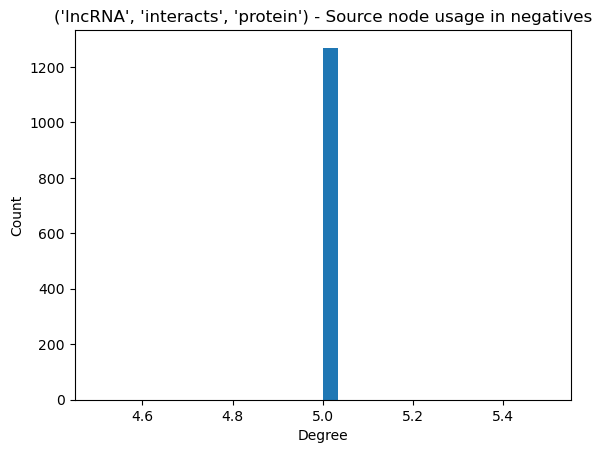

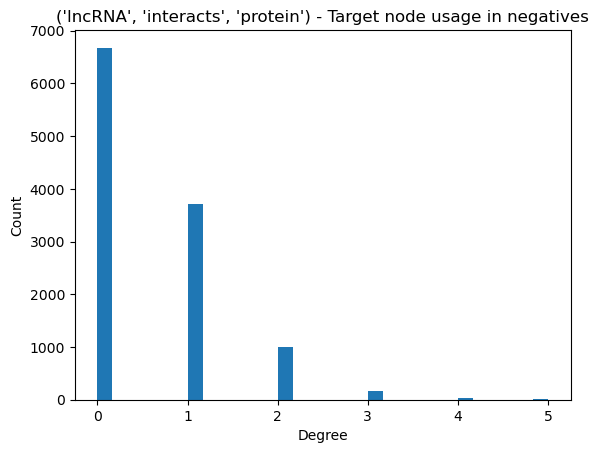


=== Inspecting edge type: ('protein', 'interacts', 'protein') ===
False negatives (negatives found in positives): 0
Unique source nodes in negatives: 11511 / 11585
Unique target nodes in negatives: 11519 / 11585


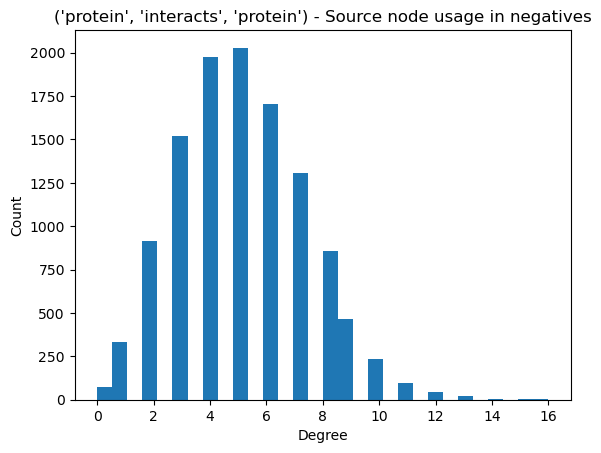

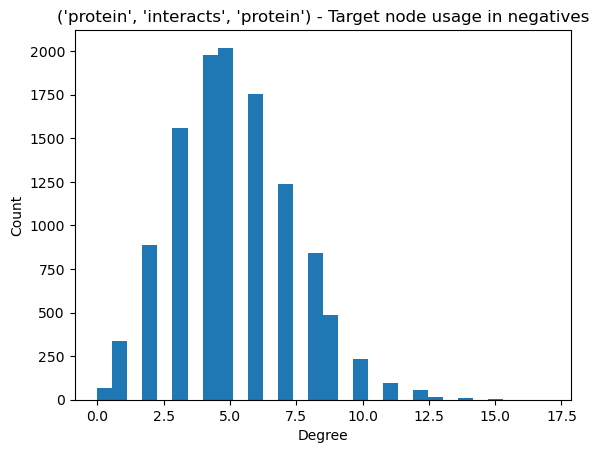

In [14]:
inspect_negative_samples_quality(train_data, train_neg_samples)


In [ ]:
"""

The negative sampling for protein–protein edges works well, with nearly all nodes included. However, for lncRNA–protein
edges, the imbalance in the number of lncRNAs vs. proteins causes issues — even after assigning 5 negative edges per lncRNA, 
6,676 protein nodes still don’t appear in any negative samples.

"""